In [55]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg

## AR model fitting: AutoReg vs ARIMA

There are two inbuilt functions in statsmodels for fitting AR models: (a) AutoReg (which we used previously), and (b) ARIMA. We compare and contrast these two ways below. We use the GNP dataset (from FRED) that we used previously. 

  observation_date      GNP
0       1947-01-01  244.142
1       1947-04-01  247.063
2       1947-07-01  250.716
3       1947-10-01  260.981
4       1948-01-01  267.133


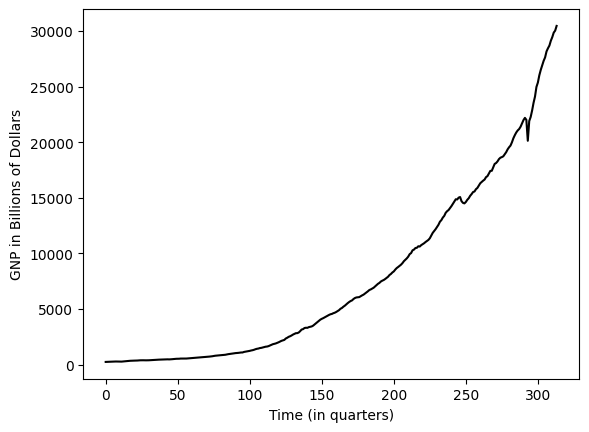

In [56]:
gnp = pd.read_csv("GNP_30Oct2025.csv")
# this is quarterly data
print(gnp.head())

y = gnp['GNP'].to_numpy()
plt.plot(y, color = 'black')
plt.xlabel('Time (in quarters)')
plt.ylabel('GNP in Billions of Dollars')
plt.show()

Instead of the raw GNP, we work with their logarithms. 

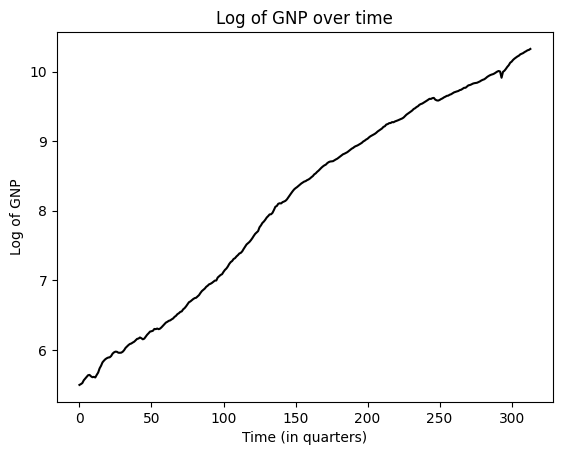

In [57]:
ylog = np.log(y)
plt.plot(ylog, color = 'black')
plt.title('Log of GNP over time')
plt.xlabel('Time (in quarters)')
plt.ylabel('Log of GNP')
plt.show()

We fit AR models to differences of the logs (after multiplying by 100). The data now becomes percent change in GNP. 

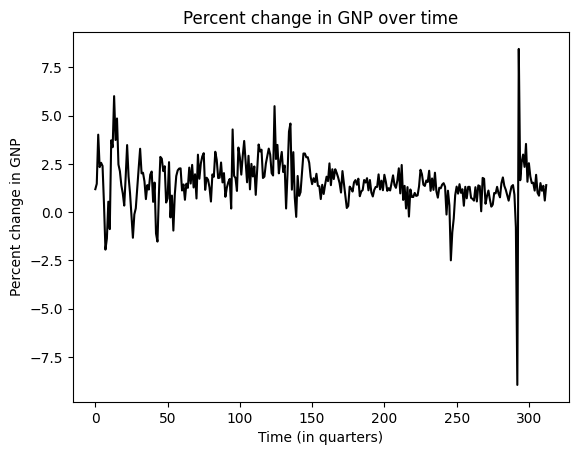

In [58]:
ylogdiff = 100 * np.diff(ylog)
plt.plot(ylogdiff, color = 'black')
plt.title('Percent change in GNP over time')
plt.xlabel('Time (in quarters)')
plt.ylabel('Percent change in GNP')
plt.show()

Let us now fit the AR(1) model to this dataset. Let us first fit it using AutoReg. 

In [59]:
md_autoreg = AutoReg(ylogdiff, lags = 1).fit()
print(md_autoreg.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  313
Model:                     AutoReg(1)   Log Likelihood                -512.052
Method:               Conditional MLE   S.D. of innovations              1.249
Date:                Sat, 15 Nov 2025   AIC                           1030.104
Time:                        16:52:44   BIC                           1041.333
Sample:                             1   HQIC                          1034.591
                                  313                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1596      0.110     10.519      0.000       0.943       1.376
y.L1           0.2487      0.055      4.536      0.000       0.141       0.356
                                    Roots           

AutoReg uses the method of conditional MLE, which maximizes the conditional likelihood of $y_2, \dots, y_n$ given $y_1$. This conditional likelihood is given by: 
\begin{equation*}
\left(\frac{1}{\sqrt{2 \pi} \sigma}
    \right)^{n-1} \exp \left(-\frac{1}{2 \sigma^2} \sum_{t=2}^n (y_t -
    \phi_0 - \phi_1 y_{t-1})^2 \right). 
\end{equation*}    


In [60]:
#the estimates of $\phi_0$ and $\phi_1$ are given by: 
print(md_autoreg.params)
#if you want the estimate of sigma^2, do the following: 
print(md_autoreg.sigma2)

[1.15955739 0.24870755]
1.5597196592023646


Next we use the ARIMA function to fit AR(1). ARIMA models have a triplet of indices $(p, d, q)$. $p$ stands for the AR order, $d$ stands for the amount of differencing, and $q$ stands for the MA order. To fit AR(1) through the ARIMA function, we need to use $p = 1$, $d = 0$ and $q = 0$. 

In [61]:
md_arima = ARIMA(ylogdiff, order = (1,0,0)).fit()
print(md_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  313
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -513.262
Date:                Sat, 15 Nov 2025   AIC                           1032.523
Time:                        16:52:44   BIC                           1043.762
Sample:                             0   HQIC                          1037.014
                                - 313                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5415      0.114     13.581      0.000       1.319       1.764
ar.L1          0.2480      0.020     12.489      0.000       0.209       0.287
sigma2         1.5551      0.041     37.640      0.0

ARIMA parametrizes the AR(1) model differently from AutoReg. It writes the AR(1) model as: 
\begin{align*}
    y_t - \mu = \phi_1 (y_{t-1} - \mu) + \epsilon_t. 
\end{align*}
In other words, there is no $\phi_0$ parameter. It is replaced by $\mu - \mu \phi_1$. This means that $\phi_0 = \mu - \mu \phi_1$ or $\mu = \phi_0/(1 - \phi_1)$. So to compare the parameter estimates given by AutoReg and ARIMA, we need to convert the estimates $\phi_0, \phi_1$  from AutoReg to $\mu, \phi_1$. 

In [62]:
pars_autoreg = [md_autoreg.params[0]/(1 - md_autoreg.params[1]), md_autoreg.params[1], md_autoreg.sigma2]
pars_arima = md_arima.params
print(np.column_stack([pars_autoreg, pars_arima]))


[[1.5434168  1.5415492 ]
 [0.24870755 0.24797155]
 [1.55971966 1.55508381]]


The parameter estimates are similar but not exactly the same. This is because ARIMA is using a different method of parameter estimation compared to AutoReg. ARIMA works with the full likelihood of $y_1, \dots, y_n$ (not the conditional likelihood of $y_2, \dots, y_n$ given $y_1$). We saw in lecture 17 that the full likelihood for AR(1) is given by: 
\begin{equation*}
\frac{\sqrt{1 - \phi_1^2}}{\sqrt{2 \pi}
      \sigma} \exp \left(-\frac{1 - \phi_1^2}{2 \sigma^2} \left(y_1 -
        \frac{\phi_0}{1 - \phi_1} \right)^2 \right) \left(\frac{1}{\sqrt{2 \pi} \sigma}
    \right)^{n-1} \exp \left(-\frac{1}{2 \sigma^2} \sum_{t=2}^n (y_t -
    \phi_0 - \phi_1 y_{t-1})^2 \right). 
\end{equation*}    
Instead of parametrizing using $\phi_0, \phi_1$ and $\sigma$, an alternative parametrization is via $\phi_1, \sigma$ and $\mu := \phi_0/(1 - \phi_1)$. With this the likelihood becomes:
\begin{equation*}
\frac{\sqrt{1 - \phi_1^2}}{\sqrt{2 \pi}
      \sigma} \exp \left(-\frac{1 - \phi_1^2}{2 \sigma^2} \left(y_1 - \mu \right)^2 \right) \left(\frac{1}{\sqrt{2 \pi} \sigma}
    \right)^{n-1} \exp \left(-\frac{1}{2 \sigma^2} \sum_{t=2}^n ((y_t - \mu)
     - \phi_1 (y_{t-1} - \mu))^2 \right). 
\end{equation*}    


The following function computes the log-likelihood given values of the parameters.

In [63]:
def loglik_ar1(dt, pars):
    n = len(dt)
    mu = pars[0]
    phi1 = pars[1]
    sigma2 = pars[2]
    sigma = np.sqrt(sigma2)
    # First term: density of y1 under stationary AR(1)
    ll_start = 0.5 * np.log(1 - phi1**2) - 0.5*np.log(2*np.pi) - np.log(sigma) \
               - (1 - phi1**2) * (dt[0] - mu)**2 / (2*sigma2)
    # Second term: density of y2,...,yn
    residuals = (dt[1:] - mu) - phi1*(dt[:-1] - mu)
    ssr = np.sum(residuals**2)
    ll_rest = -(n-1)*0.5*np.log(2*np.pi) - (n-1)*np.log(sigma) - ssr/(2*sigma2)
    return ll_start + ll_rest

We can attempt to maximize this full log-likelihood using an inbuilt optimization function, starting with the parameter estimates given by AutoReg. The code for doing this is given below. This gives almost the same results as the parameter estimates given by ARIMA. 

In [64]:
from scipy.optimize import minimize
def neg_loglik_ar1(pars, dt):
    return -loglik_ar1(dt, pars)
init_pars = pars_autoreg
bounds = [(-np.inf, np.inf), (-0.99, 0.99), (1e-6, np.inf)] 
# note that the bound on phi1 ensures stationarity
res = minimize(neg_loglik_ar1, init_pars, args=(ylogdiff,), bounds=bounds)
print("MLE estimates from custom optimization:")
print(np.column_stack([pars_autoreg, pars_arima, res.x]))
print(loglik_ar1(ylogdiff, pars_autoreg), loglik_ar1(ylogdiff, pars_arima), loglik_ar1(ylogdiff, res.x))
# check that pars_arima and res.x are very close to each other (and they give the same log-likelihood)

MLE estimates from custom optimization:
[[1.5434168  1.5415492  1.54154255]
 [0.24870755 0.24797155 0.24797565]
 [1.55971966 1.55508381 1.55511122]]
-513.2625963846933 -513.2616222294719 -513.2616221995303


Another difference between AutoReg and ARIMA is that ARIMA only searches for parameters in the causal stationary region but AutoReg does not place any such restrictions. 

In [65]:
# Below we fit these models to the original data without any differencing or logging.
md_autoreg_y = AutoReg(y, lags = 1).fit()
print(md_autoreg_y.params[1])
# AutoReg's estimate of phi1 is slightly more than 1
md_arima_y = ARIMA(y, order = (1, 0, 0)).fit()
print(md_arima_y.params[1])
#ARIMA's estimate is less than 1 (even though quite close to 1)
#Also ARIMA gives an error/warning that initial parameters that is is using are out of the stationary region. 

1.0115582545835275
0.9999135070206702


/Users/dohyeongki/miniconda3/envs/stat153/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA can be used directly on ylog (as opposed to ylogdiff). In this case, we have to give $d = 1$ (as opposed to $d = 0$). 

In [66]:
md_ylog = ARIMA(ylog*100, order = (1, 1, 0)).fit() # note that now d = 1
print(md_ylog.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  314
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -561.194
Date:                Sat, 15 Nov 2025   AIC                           1126.388
Time:                        16:52:44   BIC                           1133.880
Sample:                             0   HQIC                          1129.382
                                - 314                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6898      0.030     23.035      0.000       0.631       0.748
sigma2         2.1085      0.078     27.061      0.000       1.956       2.261
Ljung-Box (L1) (Q):                  61.43   Jarque-

The difference now is that the $\mu$ parameter is no longer present. In other words, the model that is fit here is: 
\begin{align*}
   100 \left( \log y_t - \log y_{t-1} \right) = \phi_1 100 \left( \log y_{t-1} - \log y_{t-2} \right) + \epsilon_t. 
\end{align*}
Whenever the differencing order is 1 or more, ARIMA does not use the intercept parameter. This makes a noticeable difference in predictions however. 

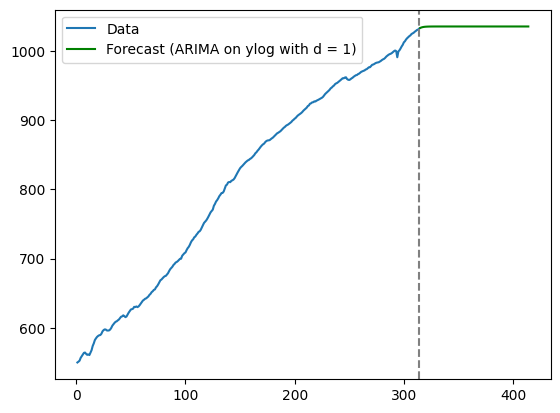

In [67]:
k = 100
n = len(ylog)
tme = range(1, n+1)
tme_future = range(n+1, n+k+1)

fcast = md_ylog.get_prediction(start = n, end = n+k-1) 
fcast_mean = fcast.predicted_mean # this gives the point predictions
plt.plot(tme, ylog*100, label = 'Data')
plt.plot(tme_future, fcast_mean, label = 'Forecast (ARIMA on ylog with d = 1)', color = 'green')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

On the other hand, if we use the model on ylogdiff, then the predictions for ylog are computed in the following way. We basically obtain predictions for the differenced series, and then use the predictions for $y_{n+1} - y_n, y_{n+2} - y_{n+1}, \dots, y_{n+k}-y_{n+k-1}$ to get predictions for $y_{n+1}, \dots, y_{n+k}$. This is done by taking telescoping sums of $y_{n+1} - y_n, y_{n+2} - y_{n+1}, \dots, y_{n+k}-y_{n+k-1}$, and then adding $y_n$. 

In [68]:
n = len(y)
k = 100
fcast_diff_1 = md_arima.get_prediction(start = n-1, end = n+k-2).predicted_mean #these are the forecasts for the differenced data
last_observed_ylog = 100*ylog[-1]
fcast_1 = np.zeros(k)
fcast_1[0] = last_observed_ylog + fcast_diff_1[0]
for i in range(1, k):
    fcast_1[i] = fcast_1[i-1] + fcast_diff_1[i]

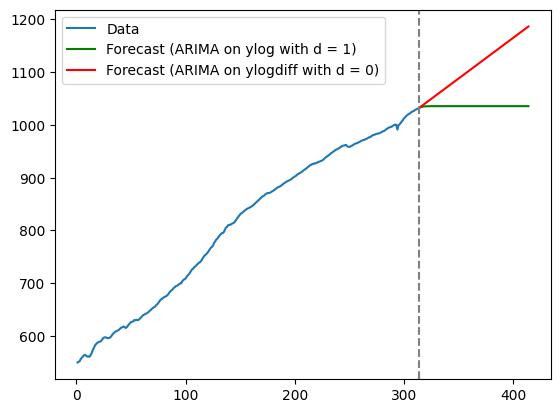

In [69]:
plt.plot(tme, ylog*100, label = 'Data')
plt.plot(tme_future, fcast_mean, label = 'Forecast (ARIMA on ylog with d = 1)', color = 'green')
plt.plot(tme_future, fcast_1, label = 'Forecast (ARIMA on ylogdiff with d = 0)', color = 'red')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

So here the presence of the intercept is leading to more intuitive predictions. 

## TTLCONS

In Lecture 21, we fit ARIMA models to the following dataset. 

  observation_date  TTLCONS
0       1993-01-01   458080
1       1993-02-01   462967
2       1993-03-01   458399
3       1993-04-01   469425
4       1993-05-01   468998
391


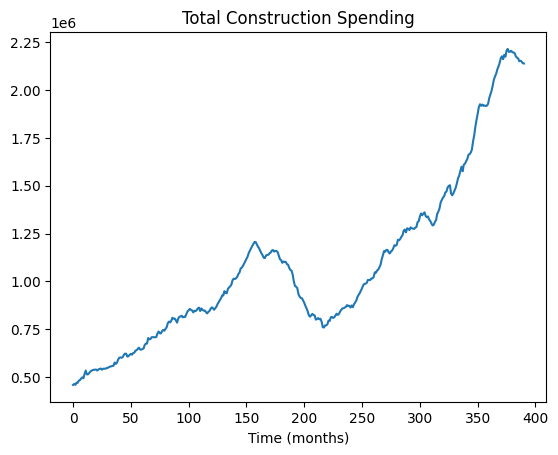

In [70]:
ttlcons = pd.read_csv('TTLCONS_13Nov2025.csv')
print(ttlcons.head())
y = ttlcons['TTLCONS'].to_numpy()
print(len(y))
plt.plot(y)
plt.title('Total Construction Spending')
plt.xlabel('Time (months)')
plt.show()

Let us revisit that analysis here again. We fit models to the logarithm of the data. 

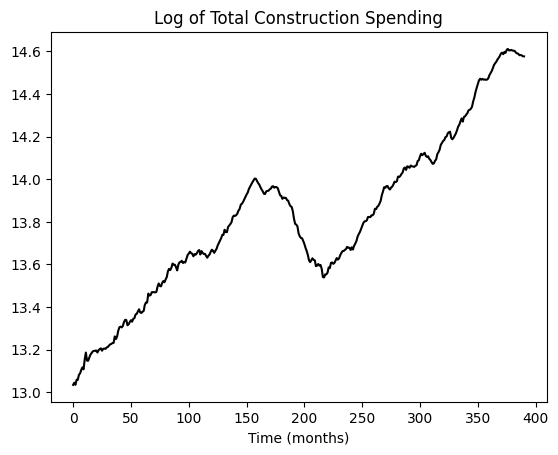

In [71]:
ylog = np.log(y)
plt.plot(ylog, color = 'black')
plt.title('Log of Total Construction Spending')
plt.xlabel('Time (months)')
plt.show()  

We can obtain candidate models by differencing the data, and looking at acf and pacf. 

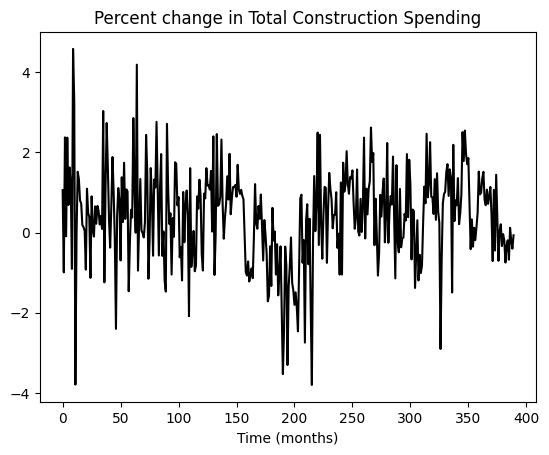

In [72]:
ylogdiff = 100 * np.diff(ylog)
plt.plot(ylogdiff, color = 'black')
plt.title('Percent change in Total Construction Spending')
plt.xlabel('Time (months)')
plt.show()

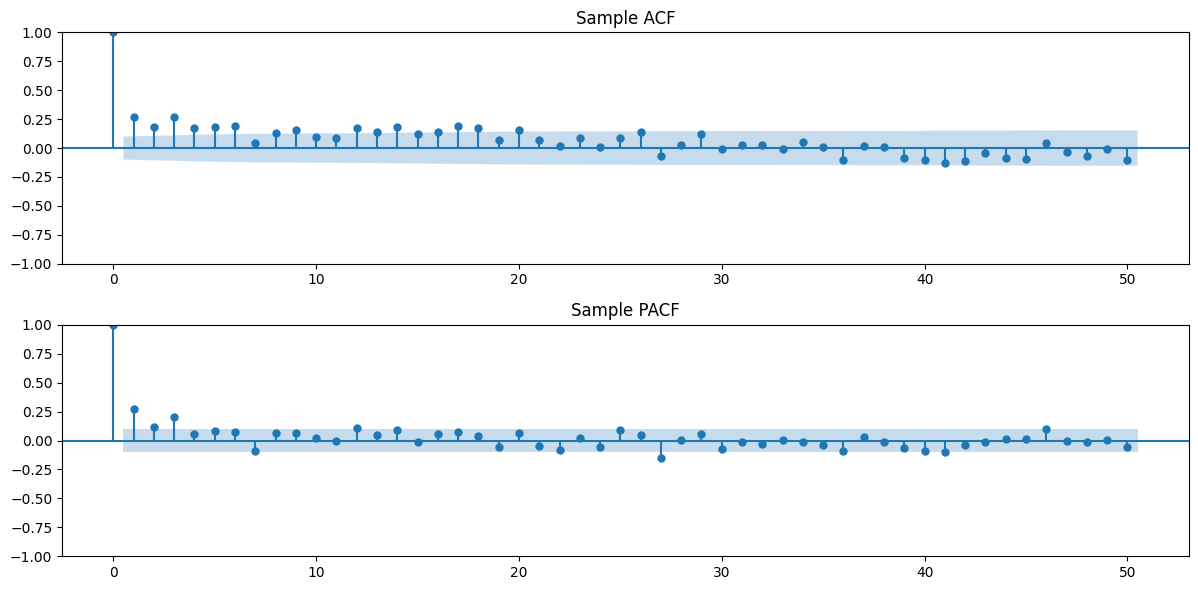

In [73]:
h_max = 50
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))
plot_acf(ylogdiff, lags = h_max, ax = axes[0])
axes[0].set_title("Sample ACF")
plot_pacf(ylogdiff, lags = h_max, ax = axes[1])
axes[1].set_title("Sample PACF")
plt.tight_layout()
plt.show()

These plots suggest: 
1. AR(3) for the differenced log data
2. MA(6) for the differenced log data
3. ARIMA(3, 1, 0) for the log data (this is technically the same as Model 1 but the ARIMA function does not include intercepts while fitting this model so it can lead to different predictions)
4. ARIMA(0, 1, 6) for the log data

We can also take another difference of the data, and then look at acf and pacf. 

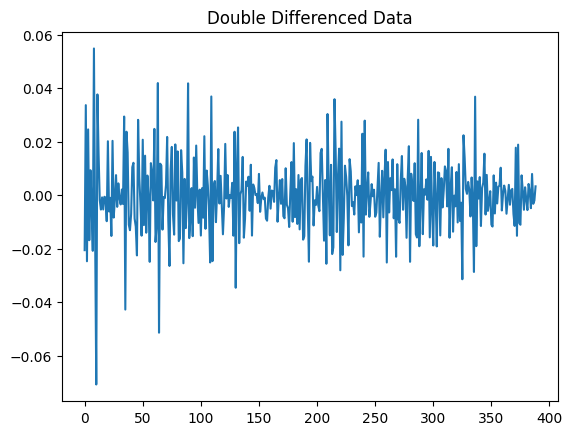

In [74]:
ylogdiff2 = np.diff(np.diff(ylog))
plt.plot(ylogdiff2)
plt.title("Double Differenced Data")
plt.show()

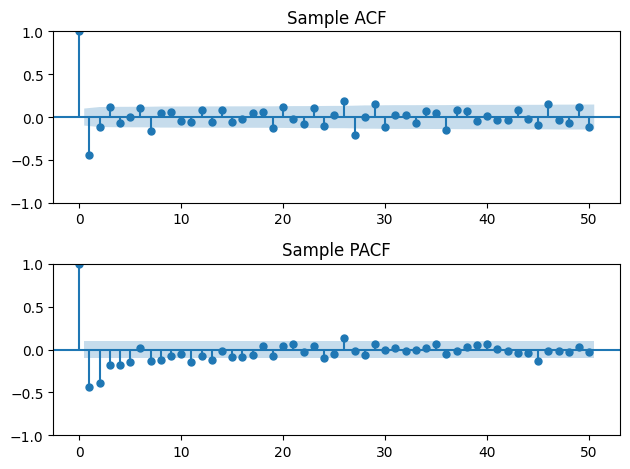

In [75]:
h_max = 50
fig, axes = plt.subplots(nrows = 2, ncols = 1)
plot_acf(ylogdiff2, lags = h_max, ax = axes[0])
axes[0].set_title("Sample ACF")
plot_pacf(ylogdiff2, lags = h_max, ax = axes[1])
axes[1].set_title("Sample PACF")
plt.tight_layout()
plt.show()

This suggests the ARIMA(0, 2, 1) model for ylog. 

Here is how to calculate the predictions for each of the five models. 

In [76]:
k = 100
n = len(ylog)
tme = range(1, n+1)
tme_future = range(n+1, n+k+1)

First is Model One: AR(3) for the differenced log data. 

In [77]:
# Model One: AR(3) for the differenced log data
md1 = ARIMA(ylogdiff, order = (3, 0, 0)).fit()
fcast_diff_1 = (md1.get_prediction(start = n-1, end = n+k-2).predicted_mean)/100 
# these are the forecasts for the differenced data
last_observed_ylog = ylog[-1]
fcast_1 = np.zeros(k)
fcast_1[0] = last_observed_ylog + fcast_diff_1[0]
for i in range(1, k):
    fcast_1[i] = fcast_1[i-1] + fcast_diff_1[i]

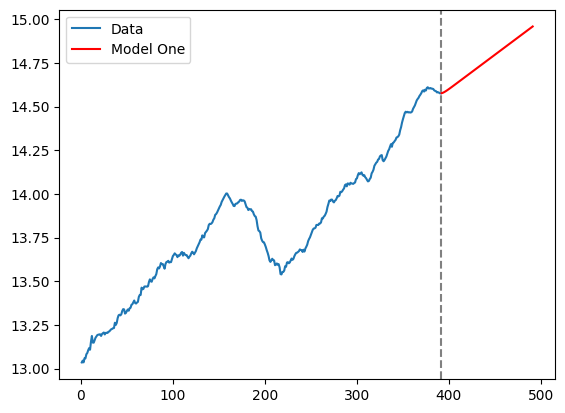

In [78]:
plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast_1, label = 'Model One', color = 'red')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

Next is Model Two: MA(6) on differenced log data. 

In [79]:
# Model Two: MA(6) for the differenced log data
md2 = ARIMA(ylogdiff, order = (0, 0, 6)).fit()
fcast_diff_2 = (md2.get_prediction(start = n-1, end = n+k-2).predicted_mean)/100 
# these are the forecasts for the differenced data
last_observed_ylog = ylog[-1]
fcast_2 = np.zeros(k)
fcast_2[0] = last_observed_ylog + fcast_diff_2[0]
for i in range(1, k):
    fcast_2[i] = fcast_2[i-1] + fcast_diff_2[i]

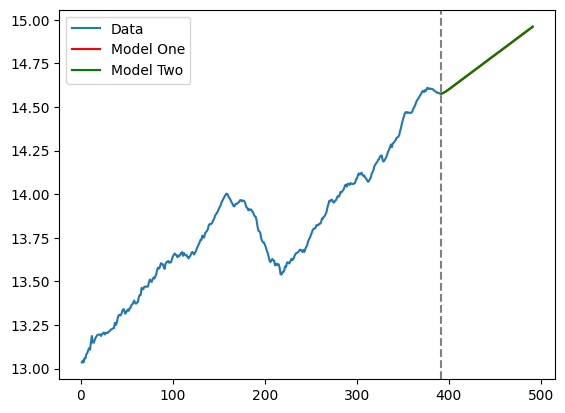

In [80]:
plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast_1, label = 'Model One', color = 'red')
plt.plot(tme_future, fcast_2, label = 'Model Two', color = 'green')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

So Model One and Model Two lead to basically the same predictions. 

Next is Model Three which ARIMA(3, 1, 0). 

In [81]:
# Model Three: ARIMA(3, 1, 0) for the log data
md3 = ARIMA(ylog, order = (3, 1, 0)).fit()
fcast_3 = md3.get_prediction(start = n, end = n+k-1).predicted_mean

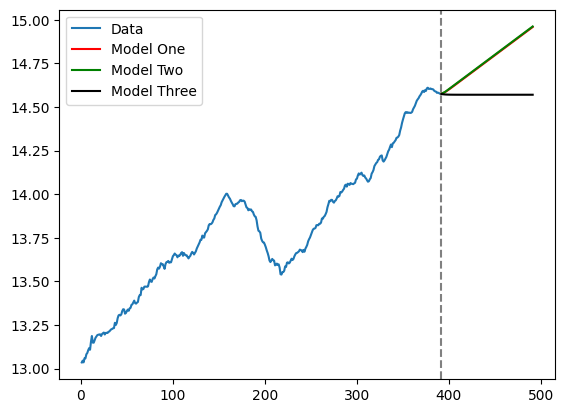

In [82]:
plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast_1, label = 'Model One', color = 'red')
plt.plot(tme_future, fcast_2, label = 'Model Two', color = 'green')
plt.plot(tme_future, fcast_3, label = 'Model Three', color = 'black')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

The lack of intercept is leading to flat predictions. 

In [83]:
#Model Four: ARIMA(0, 1, 6) for the log data
md4 = ARIMA(ylog, order = (0, 1, 6)).fit()
fcast_4 = md4.get_prediction(start = n, end = n+k-1).predicted_mean

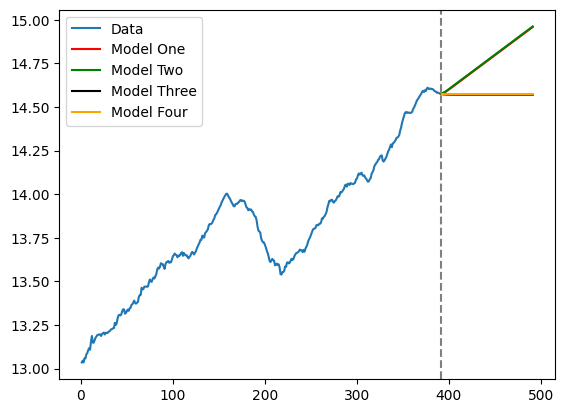

In [84]:
plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast_1, label = 'Model One', color = 'red')
plt.plot(tme_future, fcast_2, label = 'Model Two', color = 'green')
plt.plot(tme_future, fcast_3, label = 'Model Three', color = 'black')
plt.plot(tme_future, fcast_4, label = 'Model Four', color = 'orange')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

The forecasts for models 3 and 4 are largely similar. 

Finally below are the predictions for model 5. 

In [85]:
#Model Four: ARIMA(0, 2, 1) for the log data
md5 = ARIMA(ylog, order = (0, 2, 1)).fit()
fcast_5 = md5.get_prediction(start = n, end = n+k-1).predicted_mean

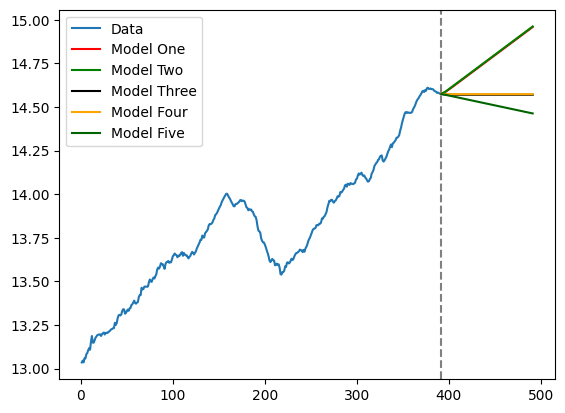

In [86]:
plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast_1, label = 'Model One', color = 'red')
plt.plot(tme_future, fcast_2, label = 'Model Two', color = 'green')
plt.plot(tme_future, fcast_3, label = 'Model Three', color = 'black')
plt.plot(tme_future, fcast_4, label = 'Model Four', color = 'orange')
plt.plot(tme_future, fcast_5, label = 'Model Five', color = 'darkgreen')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

Let us try to manually fit the AR(1) model to the double differenced data (so the model will involve an intercept), and then manually convert the predictions on the double differenced data to predictions on the original data. 

In [87]:
md6 = ARIMA(ylogdiff2, order = (0, 0, 1)).fit()
fcast_diff_6 = md6.get_prediction(start = n-2, end = n+k-3).predicted_mean

In [88]:
tmp1 = ylog[-1] - ylog[-2]
fcast_d1 = np.zeros(k)
fcast_d1[0] = tmp1 + fcast_diff_6[0]
for i in range(1, k):
    fcast_d1[i] = fcast_d1[i-1] + fcast_diff_6[i]

In [89]:
tmp2 = ylog[-1]
fcast_6 = np.zeros(k)
fcast_6[0] = tmp2 + fcast_d1[0]
for i in range(1, k):
    fcast_6[i] = fcast_6[i-1] + fcast_d1[i]

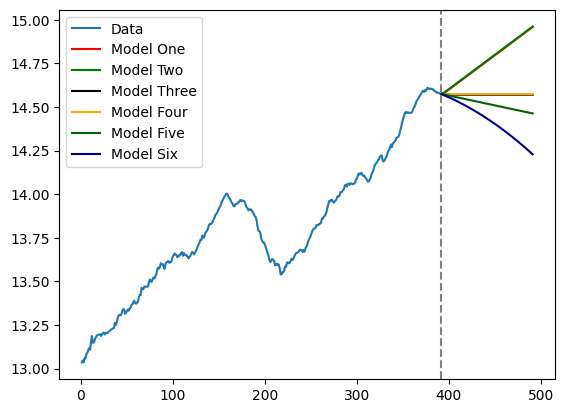

In [90]:
plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast_1, label = 'Model One', color = 'red')
plt.plot(tme_future, fcast_2, label = 'Model Two', color = 'green')
plt.plot(tme_future, fcast_3, label = 'Model Three', color = 'black')
plt.plot(tme_future, fcast_4, label = 'Model Four', color = 'orange')
plt.plot(tme_future, fcast_5, label = 'Model Five', color = 'darkgreen')
plt.plot(tme_future, fcast_6, label = 'Model Six', color = 'darkblue')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

All these models seem to give quite different predictions. Which prediction do you like?